<a href="https://colab.research.google.com/github/nikhil1111111/Pupil-Bio/blob/main/Aiims_Delhi_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import pyreadr

# Load the dataset (assuming it's in a .rds file)
result = pyreadr.read_r('/content/Dataset.rds')

# Extract the dataframe from the result
data = result[None]  # 'None' fetches the main dataframe, or you could use the key if known

# Check the structure of the dataset
print("Dataset Summary:")
print(data.info())

# Number of samples per cancer type
if 'Cancertype' in data.columns:
    cancer_type_counts = data['Cancertype'].value_counts()
    print("\nNumber of samples per cancer type:")
    print(cancer_type_counts)
else:
    print("\nColumn 'cancer_type' not found in the dataset.")

# Assuming gene expression data is all columns except 'sample_id' and 'cancer_type'
gene_expression_columns = [col for col in data.columns if col not in ['Sample', 'Cancertype']]

# Mean and standard deviation of expression levels for each gene
gene_expression = data[gene_expression_columns]
gene_expression_mean = gene_expression.mean()
gene_expression_std = gene_expression.std()

print("\nMean expression levels for each gene:")
print(gene_expression_mean)

print("\nStandard deviation of expression levels for each gene:")
print(gene_expression_std)

# Top 5 most variable genes across all samples (based on standard deviation)
gene_variability = gene_expression_std.sort_values(ascending=False)
top_5_variable_genes = gene_variability.head(5)
print("\nTop 5 most variable genes:")
print(top_5_variable_genes)


Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9263 entries, 0 to 9262
Columns: 718 entries, Sample to ZWINT
dtypes: category(1), float64(716), object(1)
memory usage: 50.7+ MB
None

Number of samples per cancer type:
Cancertype
BRCA    1119
UCEC     554
KIRC     542
LUAD     541
LGG      532
THCA     513
HNSC     504
LUSC     502
PRAD     501
COAD     483
SKCM     472
OV       430
STAD     420
BLCA     414
LIHC     374
CESC     306
KIRP     291
LAML     178
GBM      170
READ     167
ACC       79
KICH      66
UCS       57
DLBC      48
Name: count, dtype: int64

Mean expression levels for each gene:
ABCC1        9.915659
ABL1        12.012779
ACD        133.470830
ACTB      2560.107525
ACTL6A      46.466199
             ...     
ZNF451       6.638263
ZNHIT1     287.094208
ZRANB3       0.230155
ZSWIM7      13.266532
ZWINT      160.347854
Length: 716, dtype: float64

Standard deviation of expression levels for each gene:
ABCC1       11.257589
ABL1         5.519803
ACD 


Top 10 differentially expressed genes:
        gene        p_value
405  PITPNM1  5.510189e-181
452   PPP4R1  1.255681e-176
336      MVP  4.369125e-152
24        AR  1.435229e-124
597   SUPT7L  4.224769e-110
355   NFKBIA  6.145206e-107
539   SETMAR  8.287998e-107
434   POLR2C   1.825848e-98
683     USP7   1.892654e-94
394     PER1   1.600363e-93


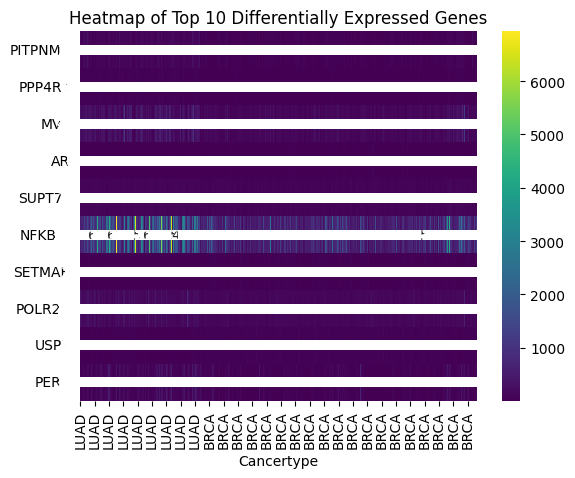

In [16]:
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# Function to perform t-test and find differentially expressed genes
def find_de_genes(data, cancer_type1, cancer_type2):
    group1 = data[data['Cancertype'] == cancer_type1].drop(columns=['Sample', 'Cancertype'])
    group2 = data[data['Cancertype'] == cancer_type2].drop(columns=['Sample', 'Cancertype'])
    p_values = []
    for gene in group1.columns:
        t_stat, p_val = ttest_ind(group1[gene], group2[gene])
        p_values.append(p_val)
    de_genes = pd.DataFrame({'gene': group1.columns, 'p_value': p_values})
    de_genes = de_genes.sort_values(by='p_value').head(10)
    return de_genes

# Example: Compare two cancer types
de_genes = find_de_genes(data, 'BRCA', 'LUAD')
print("\nTop 10 differentially expressed genes:")
print(de_genes)

# Heatmap visualization
top_genes = de_genes['gene'].tolist()
heatmap_data = data[data['Cancertype'].isin(['BRCA', 'LUAD'])][top_genes + ['Cancertype']]
heatmap_data = heatmap_data.set_index('Cancertype')
sns.heatmap(heatmap_data.T, cmap='viridis', annot=True, fmt=".2f")
plt.title("Heatmap of Top 10 Differentially Expressed Genes")
plt.show()

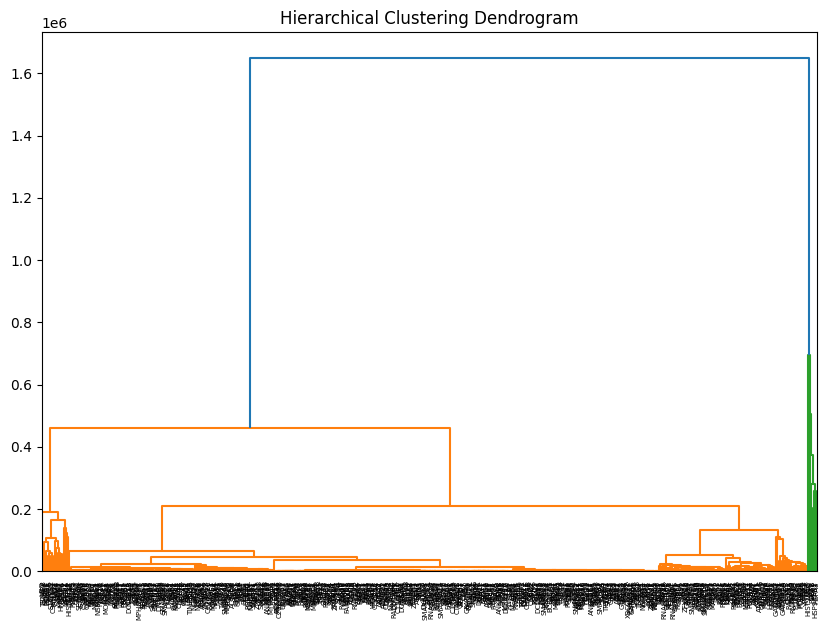

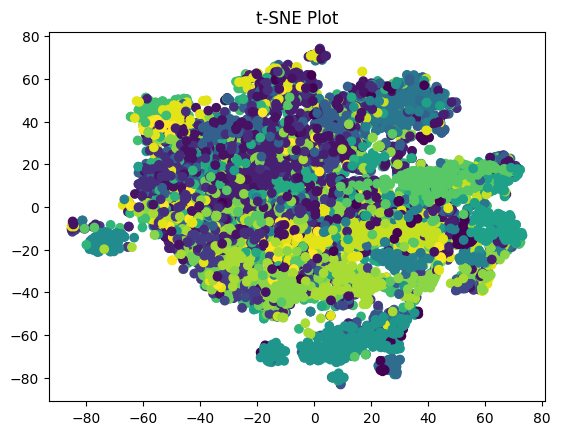

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE

# Hierarchical clustering
linked = linkage(gene_expression.T, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=gene_expression.columns, orientation='top')
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(gene_expression)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=data['Cancertype'].astype('category').cat.codes)
plt.title("t-SNE Plot")
plt.show()

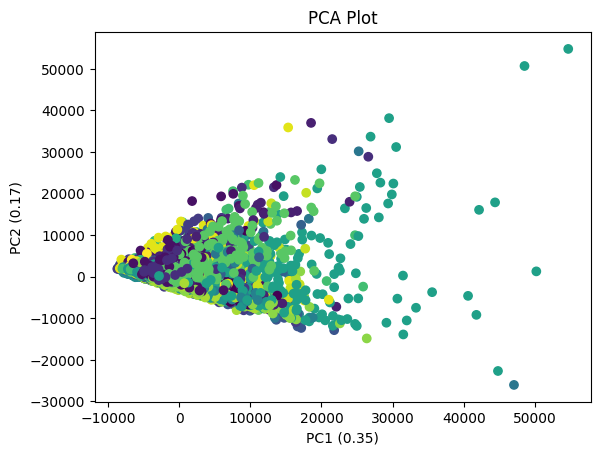

In [19]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(gene_expression)

# Plot PCA results
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=data['Cancertype'].astype('category').cat.codes)
plt.title("PCA Plot")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2f})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2f})")
plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(gene_expression, data['Cancertype'], test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))


Accuracy: 0.9217485159201295
Precision: 0.9099273479820604
Recall: 0.9217485159201295
F1-Score: 0.9132157805956058


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# Get feature importance
feature_importance = pd.DataFrame({'gene': gene_expression.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
print("\nTop genes with highest predictive value:")
print(feature_importance.head(10))


Top genes with highest predictive value:
       gene  importance
204    ESR1    0.016649
646    TP63    0.015663
445   PPARG    0.011388
24       AR    0.011100
258    HIRA    0.008850
102    CDK2    0.008806
81    CCNA1    0.006776
121  CLASP2    0.006705
272    IDH1    0.006386
525   RREB1    0.006324


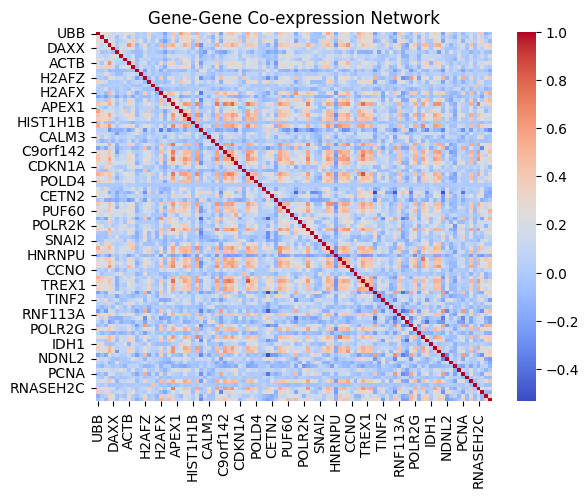

In [23]:
top_100_genes = gene_variability.head(100).index
top_100_data = gene_expression[top_100_genes]

# Compute correlation matrix
correlation_matrix = top_100_data.corr()

# Visualize correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title("Gene-Gene Co-expression Network")
plt.show()
